In [2]:
PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"
import sys
sys.path.append("..")

from modules.learning.models import *
from modules.learning.train import train_model
from modules.utils import hc
from modules.visualize import plot_loss, plot_normalized_time_error

# from modules.learning.evaluate import Evaluation, get_latent_space, plot_umap
from matplotlib import pyplot as plt
from modules.learning.dycep import DYCEP
import json
from types import SimpleNamespace


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# enet = EfficientNet()

track_path = PATH + "track_datasets/control_mm/train/images/"
# track_path_drug = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/datasets/mTOR/images/"
label_path = PATH + "track_datasets/control_mm/train/labels/"
# label_path_drug = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/datasets/mTOR/labels/"



in_channels = [1]

expandable_segments:True


In [3]:
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_ndim, dtw_ndim_visualisation, dtw_visualisation

# loading data

In [4]:
import os
cells = os.listdir(label_path)[:]

tracks = []

for cell in cells:
    track = np.load(label_path + cell).squeeze().T
    tracks.append(track)

In [18]:
16*16

256

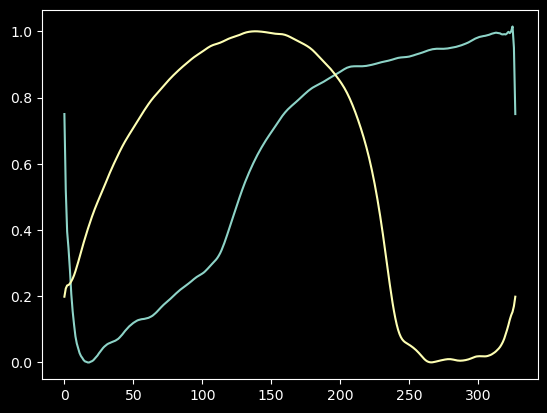

In [5]:
from helper_fn import *

ref_length = 328

fourier = np.load("coef_fourier.npy")

tau_ref = np.linspace(0, 1, ref_length)
btr = vanilla_fn(tau_ref, coeffs=fourier)

plt.plot(btr)

In [6]:
# concatenate tau_ref with itself alonf the axis=1
v = np.concatenate((tau_ref.reshape(-1, 1), tau_ref.reshape(-1, 1)), axis=1)
class_ref = phase2class(v)
durations_ref = class_duration(class_ref)
hours_ref = durations_ref * 5 / 60

## tuning thewarping parameters

216


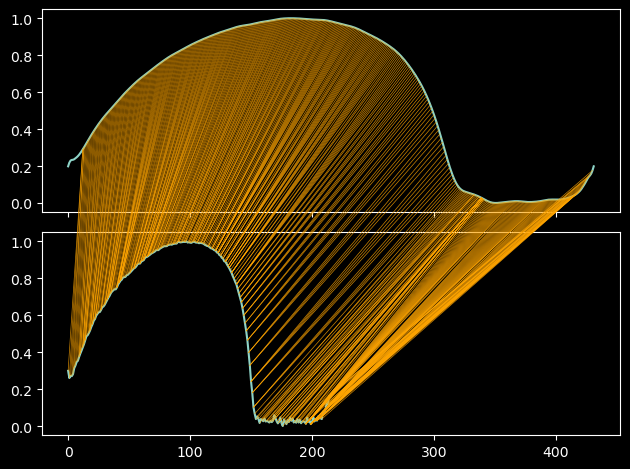

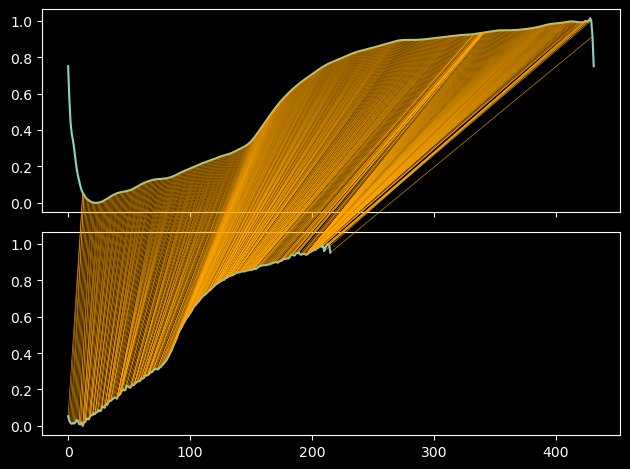

ref_len 432
12 430
track_len 216
0 215


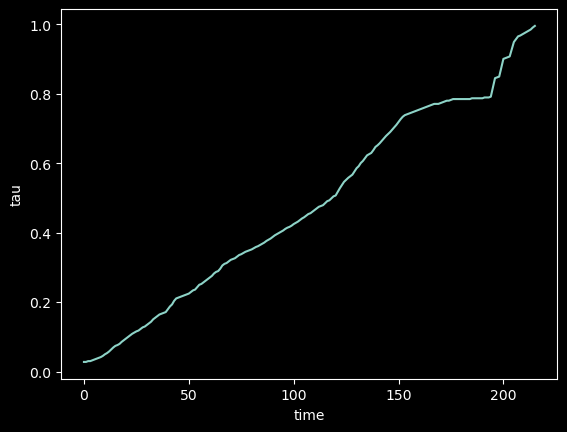

In [12]:
idx = np.random.choice(len(tracks))
# idx = 4516

len_factor = 2

track0 = tracks[idx]
track0 = track0[:]
tr_len, ref_len = track0.shape[0], track0.shape[0] * len_factor
tau = np.linspace(0, 1, ref_len)
btr = vanilla_fn(tau, coeffs=fourier)

print(len(track0))


x = np.load(track_path + cells[idx], allow_pickle=True)

window_size = 1
penalty = None
psi=(ref_len // 2, ref_len // 2, 0 , 0)
# psi=(0, 0, 0 , 0)

d, wpath = dtw_ndim.warping_paths(btr, track0, window=window_size, penalty=penalty, psi=psi)
best_path = np.array(dtw.best_path(wpath))
    
dtw_visualisation.plot_warping(btr[:, 1], track0[:, 1], best_path)
dtw_visualisation.plot_warping(btr[:, 0], track0[:, 0], best_path)
plt.show()

out = phase_map(best_path, ref_len)
plt.plot(out)
plt.ylabel("tau")
plt.xlabel("time")

print("ref_len", ref_len)
print(best_path[:, 0].min(), best_path[:,0].max())
print("track_len", tr_len)
print(best_path[:, 1].min(), best_path[:,1].max())

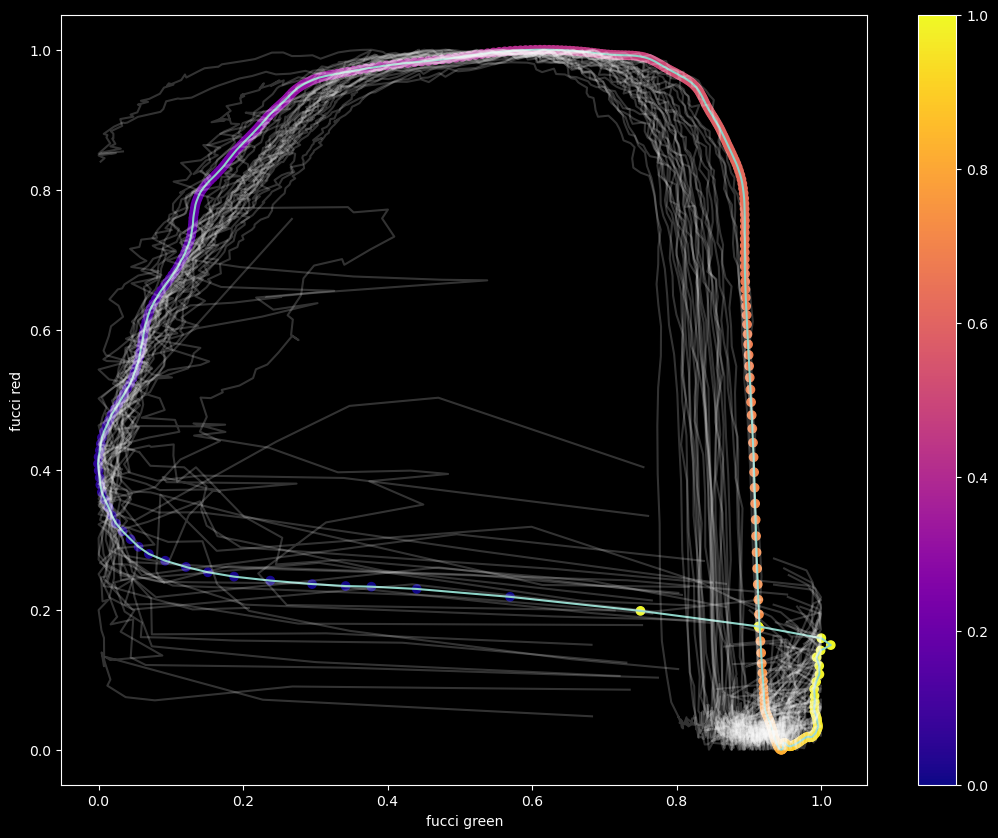

In [13]:
# plot and color with time
plt.figure(figsize=(13, 10))

plt.plot(btr[:, 0], btr[:, 1], label="ref")
plt.scatter(btr[:, 0] , btr[:, 1], c=tau, cmap="plasma")

for tr in tracks[:30]:
    plt.plot(tr[:, 0], tr[:, 1], alpha=0.2, color="white") 

plt.xlabel("fucci green")
plt.ylabel("fucci red")
plt.colorbar()

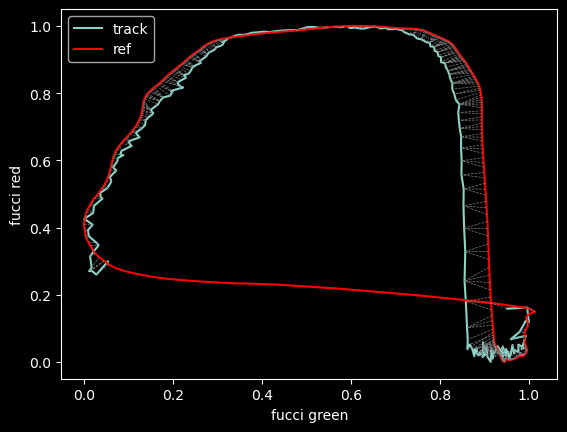

In [16]:
plt.plot(track0[:, 0], track0[:, 1], label="track")
plt.plot(btr[:, 0], btr[:, 1], label="ref", color="red")

for i, j in best_path:
    plt.plot(
        [btr[i, 0], track0[j, 0]],  # btr first, track0 second
        [btr[i, 1], track0[j, 1]],
        color="gray",
        linestyle="--",
        linewidth=0.5,
    )

plt.xlabel("fucci green")
plt.ylabel("fucci red")
plt.legend()

In [17]:
import stackview
stackview.slice(x, zoom_factor=4)

# running on all tracks

In [8]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

len_factor = 2
window_size = None
penalty = None


In [ ]:
# warping all tracks, not in parallel

# best_paths = []

# for i, track in enumerate(tqdm(tracks)):
    
#     tr_len, ref_len = track.shape[0], track.shape[0] * len_factor
#     tau = np.linspace(0, 1, ref_len)
#     btr = vanilla_fn(tau, coeffs=fourier)

#     psi=(ref_len // 2, 10, 0 , 0)

#     d, wpath = dtw_ndim.warping_paths(btr, track, window=window_size, penalty=penalty, psi=psi)
#     best_path = np.array(dtw.best_path(wpath))

#     best_paths.append(best_path)


In [9]:
def process_track(args):
    track, len_factor, fourier, window_size, penalty = args
    tr_len, ref_len = track.shape[0], track.shape[0] * len_factor
    tau = np.linspace(0, 1, ref_len)
    btr = vanilla_fn(tau, coeffs=fourier)
    
    psi = (ref_len // 2, 10, 0, 0)
    d, wpath = dtw_ndim.warping_paths(btr, track, window=window_size, penalty=penalty, psi=psi)
    best_path = np.array(dtw.best_path(wpath))
    out = phase_map(best_path, ref_len)

    return best_path, out

args = [(track, len_factor, fourier, window_size, penalty) for track in tracks]

best_paths = []
phases = []
with ProcessPoolExecutor() as executor:
    for result in tqdm(executor.map(process_track, args), total=len(tracks)):
        best_path, out = result  # Unpack the two outputs
        best_paths.append(best_path)  # Save best_path
        phases.append(out)  


100%|██████████| 5189/5189 [02:24<00:00, 35.94it/s]


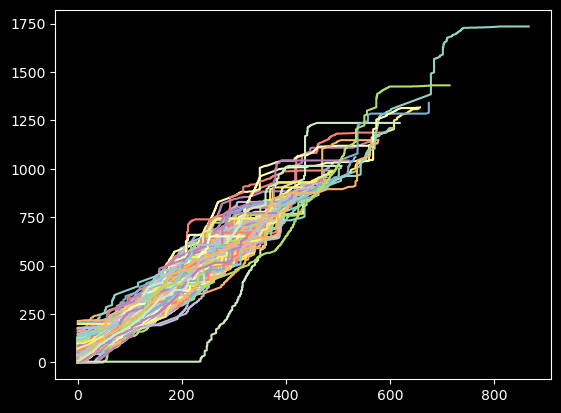

In [10]:
for i, best_path in enumerate(best_paths):
    # tru, out = phase_map(best_path, ref_len)
    plt.plot(best_path[:, 1], best_path[:, 0])

In [12]:
# save phases list in GT folder

np.save("GT/paths.npy", best_paths)
np.save("GT/phases.npy", phases)


/home/maxine/miniconda3/envs/star/lib/python3.8/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Text(0, 0.5, 'phase')

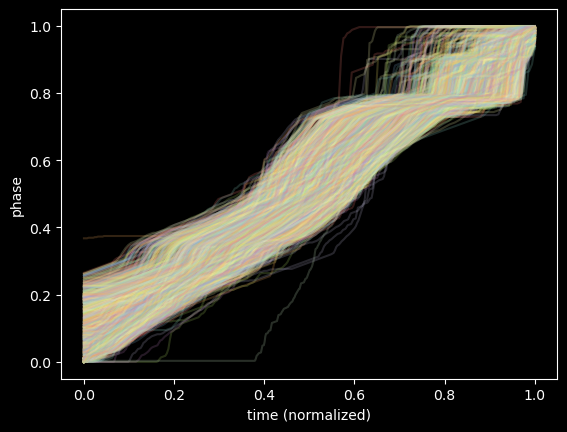

In [13]:
for i, ph in enumerate(phases):
    # tru, out = phase_map(best_path, ref_len)
    tau = np.linspace(0, 1, len(ph))
    plt.plot(tau, ph, alpha=0.2)

plt.xlabel("time (normalized)")
plt.ylabel("phase")